# Look at MI estimation vs. Reconstruction performance 

Use 2000 images for reconstruction sets, use 10,000 images for MI estimation.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from skimage import metrics
from black_hole_helpers import *

In [ ]:
num_bootstraps = 100
test_set_length = 2000 # have 2k recons in each directory
#test_set_options = [100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000] # MI will always be the last index in these, using MI with 10k test set

base_folder = '/home/your_username/black_holes/' 

telescope_indices = list(range(70))

special_telescope_indices = [10, 21, 22] # these three correspond to the selected telescopes used in the main figure of the paper 
# 10 is alma apex pv smt
# 21 is jcmt sma alma pv 
# 22 is pv sma spt apex 

telescope_names = ['observations_combination_{}'.format(i) for i in telescope_indices]
folders = [base_folder + telescope_name + '/' for telescope_name in telescope_names]
save_dir = '/home/your_username/black_holes/mi_estimates_all_combinations/'

gt_folder = base_folder + 'sources_06_07/'

In [3]:
def correct_for_sigma_scaling(sigma_length):
    # H(Y | X) adds a 2 * sum log(sigma * 255 / 2) / log(2) 
    # so here, have 2 * sigma_length * log(255/2) / log(2) 
    # this term will be subtracted from (H(Y) - H(Y | X) / log(2): - correction_factor
    return 2 * sigma_length * np.log(255.0/2.0) / np.log(2.0)

In [4]:
# get sigma values for use in correction 
sigma_lengths = [] 
for folder in folders: 
    sigma_list = np.load(folder + 'sigmas/0.npy')
    sigma_lengths.append(sigma_list.shape[0])

In [5]:
image_idx_start = 0 # TODO can change
image_idx_end = test_set_length # for now matching the same as the data that's being reconned

gt_min, gt_max = check_max_value_in_folder(gt_folder, image_idx_end - image_idx_start, start_idx=image_idx_start, file_prefix='black_hole_')

data_range_set_final = gt_max - gt_min

Min: 0.0, Max: 0.003630544035692477


Bootstrapping to compute confidence interval: 100%|██████████| 100/100 [00:00<00:00, 17629.79it/s]


Text(0.5, 1.0, 'SSIM')

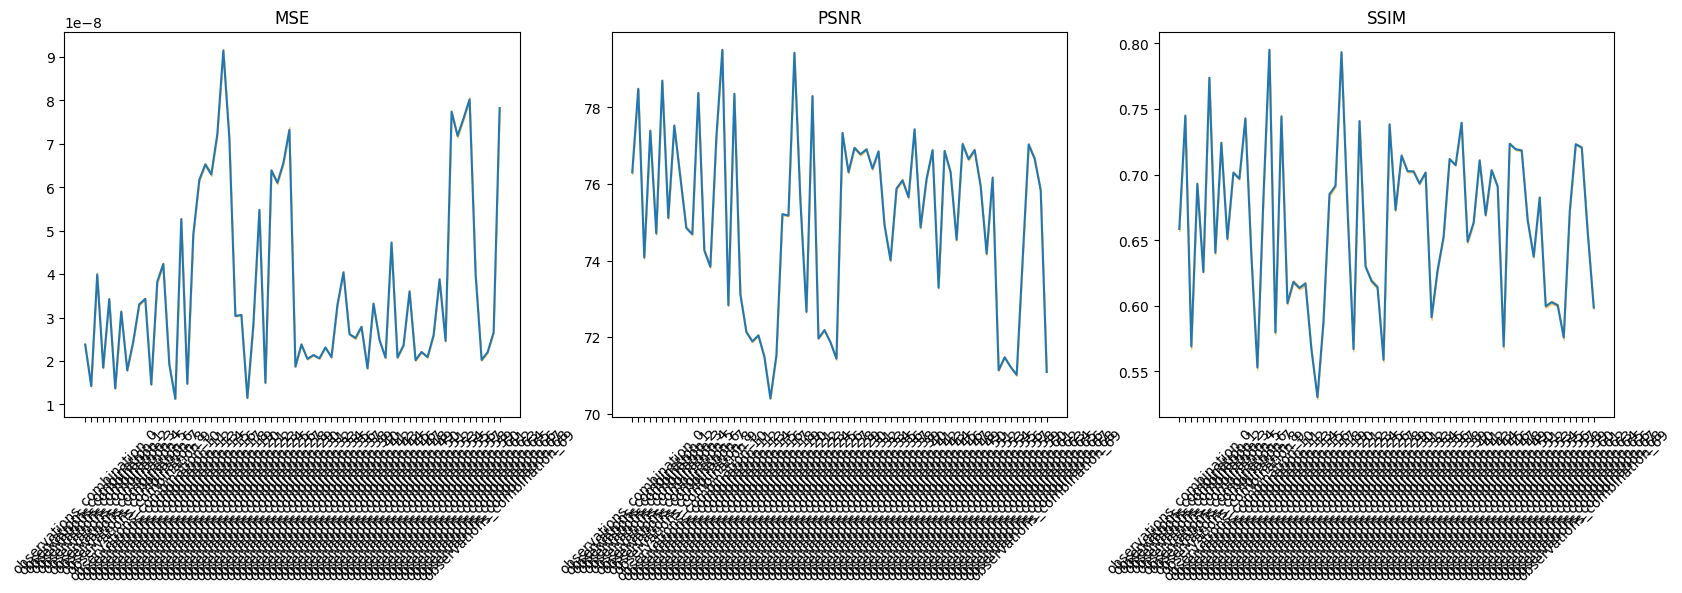

In [6]:
image_idx_start = 0 
image_idx_end = image_idx_start + test_set_length

mse_means = []
mse_lower_bounds = []
mse_upper_bounds = []
psnr_means = []
psnr_lower_bounds = []
psnr_upper_bounds = []
ssim_means = []
ssim_lower_bounds = []
ssim_upper_bounds = []

for inpath in folders: 
    outpath = inpath + 'rml_recons/'

    mses, psnrs, ssims = compute_metrics_for_test_set(outpath, gt_folder, data_range_set_final, start_idx=image_idx_start, test_set_length=test_set_length)
    bootstrap_mses, bootstrap_psnrs, bootstrap_ssims = compute_bootstraps(mses, psnrs, ssims, test_set_length, num_bootstraps=num_bootstraps)

    mean_mse, lower_bound_mse, upper_bound_mse = compute_confidence_interval(bootstrap_mses, confidence_interval=0.95)
    mean_psnr, lower_bound_psnr, upper_bound_psnr = compute_confidence_interval(bootstrap_psnrs, confidence_interval=0.95)
    mean_ssim, lower_bound_ssim, upper_bound_ssim = compute_confidence_interval(bootstrap_ssims, confidence_interval=0.95)
    
    mse_means.append(mean_mse)
    mse_lower_bounds.append(lower_bound_mse)
    mse_upper_bounds.append(upper_bound_mse)
    psnr_means.append(mean_psnr)
    psnr_lower_bounds.append(lower_bound_psnr)
    psnr_upper_bounds.append(upper_bound_psnr)
    ssim_means.append(mean_ssim)
    ssim_lower_bounds.append(lower_bound_ssim)
    ssim_upper_bounds.append(upper_bound_ssim)
        

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(mse_means)
plt.fill_between(range(len(mse_means)), mse_lower_bounds, mse_upper_bounds, alpha=0.5, color='orange')
plt.xticks(np.arange(len(telescope_names)), telescope_names, rotation=45)
plt.title("MSE")
plt.subplot(1, 3, 2)
plt.plot(psnr_means)
plt.fill_between(range(len(psnr_means)), psnr_lower_bounds, psnr_upper_bounds, alpha=0.5, color='orange')
plt.xticks(np.arange(len(telescope_names)), telescope_names, rotation=45)
plt.title("PSNR")
plt.subplot(1, 3, 3)
plt.plot(ssim_means)
plt.fill_between(range(len(ssim_means)), ssim_lower_bounds, ssim_upper_bounds, alpha=0.5, color='orange')
plt.xticks(np.arange(len(telescope_names)), telescope_names, rotation=45)
plt.title("SSIM")


In [7]:
mi_values = [] 
mi_lower_bounds = [] 
mi_upper_bounds = [] 
uncorrected_mi_values = []
for folder_idx, folder in enumerate(folders): 
    results = np.load(save_dir + '{}_main_code_no_uniform_noise.npy'.format(telescope_names[folder_idx]))
    # only want the last index corresponding to 10k test set size 
    # also need to correct for sigma scaling 
    mi_values.append(results[-1, 0] - correct_for_sigma_scaling(sigma_lengths[folder_idx]))
    mi_lower_bounds.append(results[-1, 1] - correct_for_sigma_scaling(sigma_lengths[folder_idx]))
    mi_upper_bounds.append(results[-1, 2] - correct_for_sigma_scaling(sigma_lengths[folder_idx]))
    uncorrected_mi_values.append(results[-1, 0])

## Sidebar: plot MI values before and after sigma scaling

In [15]:
print(np.max(uncorrected_mi_values), np.argmax(uncorrected_mi_values))

22422.44066419012 46


In [16]:
print(np.max(mi_values), np.argmax(mi_values))

359.703039045864 47


In [17]:
print(uncorrected_mi_values[46:48])

[22422.44066419012, 20027.824903492972]


In [18]:
print(mi_values[46:48])

[264.3289762212589, 359.703039045864]


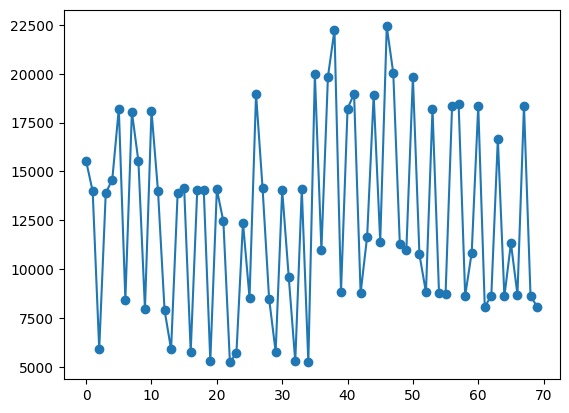

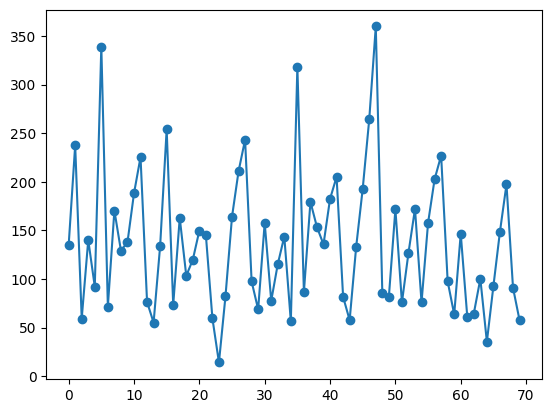

In [19]:
plt.plot(uncorrected_mi_values, '-o')
plt.figure()
plt.plot(mi_values, '-o')

### This plot includes corrected sigma values - this is important! Because the data was scaled to 0-255 there is a corresponding scaling for the sigmas. Excluding errorbars for now.

Text(0.5, 1.02, 'Reconstruction Metrics vs. Mutual Information for 70 Telescopes')

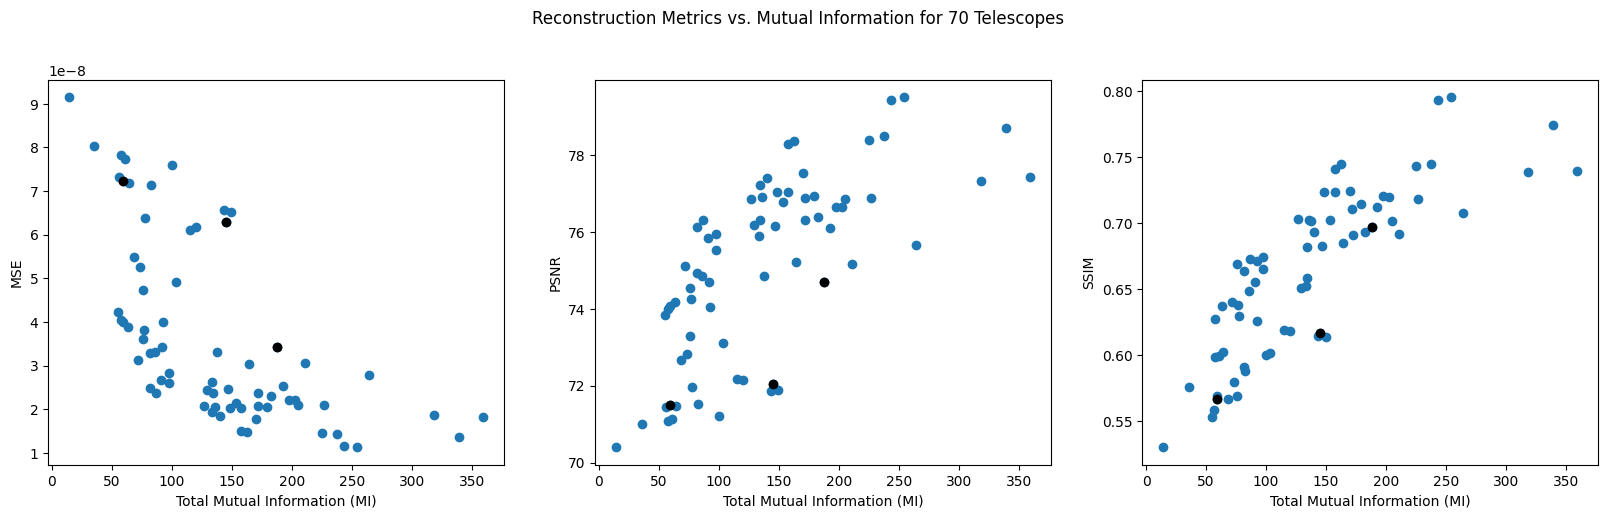

In [9]:
lower_bounds_x = np.abs(np.array(mi_values) - np.array(mi_lower_bounds))
upper_bounds_x = np.abs(np.array(mi_upper_bounds) - np.array(mi_values))
plt.figure(figsize=(20, 5)) 
plt.subplot(1, 3, 1) 
# bounds for MSE 
lower_bounds_y = np.abs(np.array(mse_means) - np.array(mse_lower_bounds))
upper_bounds_y = np.abs(np.array(mse_upper_bounds) - np.array(mse_means))
plt.scatter(mi_values, mse_means) 
plt.scatter(np.array(mi_values)[special_telescope_indices], np.array(mse_means)[special_telescope_indices], color='black')
#plt.errorbar(mi_values, mse_means, yerr=[lower_bounds_y, upper_bounds_y], xerr=[lower_bounds_x, upper_bounds_x], fmt='o', capsize=5, ecolor='blue', markersize=8, barsabove=True)
# plot special ones in a different color. 

plt.xlabel("Total Mutual Information (MI)")
plt.ylabel("MSE") 

plt.subplot(1, 3, 2)
# bounds for PSNR 
lower_bounds_y = np.abs(np.array(psnr_means) - np.array(psnr_lower_bounds))
upper_bounds_y = np.abs(np.array(psnr_upper_bounds) - np.array(psnr_means))
plt.scatter(mi_values, psnr_means)
plt.scatter(np.array(mi_values)[special_telescope_indices], np.array(psnr_means)[special_telescope_indices], color='black')
#plt.errorbar(mi_values, psnr_means, yerr=[lower_bounds_y, upper_bounds_y], xerr=[lower_bounds_x, upper_bounds_x], fmt='o', capsize=5, ecolor='blue', markersize=8, barsabove=True)
plt.xlabel("Total Mutual Information (MI)")
plt.ylabel("PSNR")

plt.subplot(1, 3, 3)
# bounds for SSIM
lower_bounds_y = np.abs(np.array(ssim_means) - np.array(ssim_lower_bounds))
upper_bounds_y = np.abs(np.array(ssim_upper_bounds) - np.array(ssim_means))
plt.scatter(mi_values, ssim_means)
plt.scatter(np.array(mi_values)[special_telescope_indices], np.array(ssim_means)[special_telescope_indices], color='black')
#plt.errorbar(mi_values, ssim_means, yerr=[lower_bounds_y, upper_bounds_y], xerr=[lower_bounds_x, upper_bounds_x], fmt='o', capsize=5, ecolor='blue', markersize=8, barsabove=True)
plt.xlabel("Total Mutual Information (MI)")
plt.ylabel("SSIM")

plt.suptitle("Reconstruction Metrics vs. Mutual Information for {} Telescopes".format(len(telescope_names)), y=1.02)

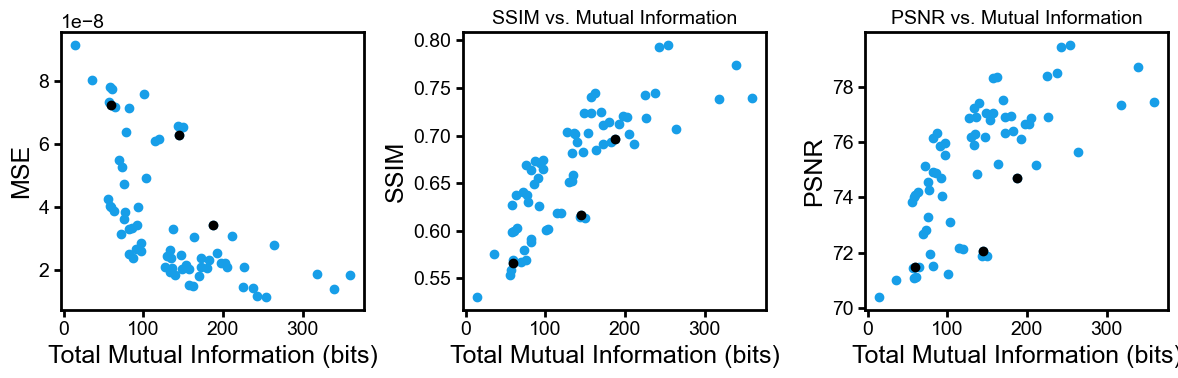

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from cleanplots import *
from matplotlib.ticker import ScalarFormatter

lower_bounds_x = np.abs(np.array(mi_values) - np.array(mi_lower_bounds))
upper_bounds_x = np.abs(np.array(mi_upper_bounds) - np.array(mi_values))
figs, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
# bounds for MSE 
lower_bounds_y = np.abs(np.array(mse_means) - np.array(mse_lower_bounds))
upper_bounds_y = np.abs(np.array(mse_upper_bounds) - np.array(mse_means))
axs[0].scatter(mi_values, mse_means) 
axs[0].scatter(np.array(mi_values)[special_telescope_indices], np.array(mse_means)[special_telescope_indices], color='black')
#plt.errorbar(mi_values, mse_means, yerr=[lower_bounds_y, upper_bounds_y], xerr=[lower_bounds_x, upper_bounds_x], fmt='o', capsize=5, ecolor='blue', markersize=8, barsabove=True)
# plot special ones in a different color. 

axs[0].set_xlabel("Total Mutual Information (bits)")
axs[0].set_ylabel("MSE") 
#axs[0].set_title("MSE vs. Mutual Information")

# bounds for SSIM
lower_bounds_y = np.abs(np.array(ssim_means) - np.array(ssim_lower_bounds))
upper_bounds_y = np.abs(np.array(ssim_upper_bounds) - np.array(ssim_means))
axs[1].scatter(mi_values, ssim_means)
axs[1].scatter(np.array(mi_values)[special_telescope_indices], np.array(ssim_means)[special_telescope_indices], color='black')
#plt.errorbar(mi_values, ssim_means, yerr=[lower_bounds_y, upper_bounds_y], xerr=[lower_bounds_x, upper_bounds_x], fmt='o', capsize=5, ecolor='blue', markersize=8, barsabove=True)
axs[1].set_xlabel("Total Mutual Information (bits)")
axs[1].set_ylabel("SSIM")
axs[1].set_title("SSIM vs. Mutual Information")

# bounds for PSNR 
lower_bounds_y = np.abs(np.array(psnr_means) - np.array(psnr_lower_bounds))
upper_bounds_y = np.abs(np.array(psnr_upper_bounds) - np.array(psnr_means))
axs[2].scatter(mi_values, psnr_means)
axs[2].scatter(np.array(mi_values)[special_telescope_indices], np.array(psnr_means)[special_telescope_indices], color='black')
#plt.errorbar(mi_values, psnr_means, yerr=[lower_bounds_y, upper_bounds_y], xerr=[lower_bounds_x, upper_bounds_x], fmt='o', capsize=5, ecolor='blue', markersize=8, barsabove=True)
axs[2].set_xlabel("Total Mutual Information (bits)")
axs[2].set_ylabel("PSNR")
axs[2].set_title("PSNR vs. Mutual Information")

#plt.suptitle("Reconstruction Metrics vs. Mutual Information for {} Telescopes".format(len(telescope_names)), y=1.02)
plt.tight_layout()
#plt.savefig("black_hole_recon_metrics_vs_mi_full.pdf", transparent=True)

## Archive Plots - before sigma was corrected for.

Text(0.5, 1.02, 'Reconstruction Metrics vs. Mutual Information for 34 Telescopes')

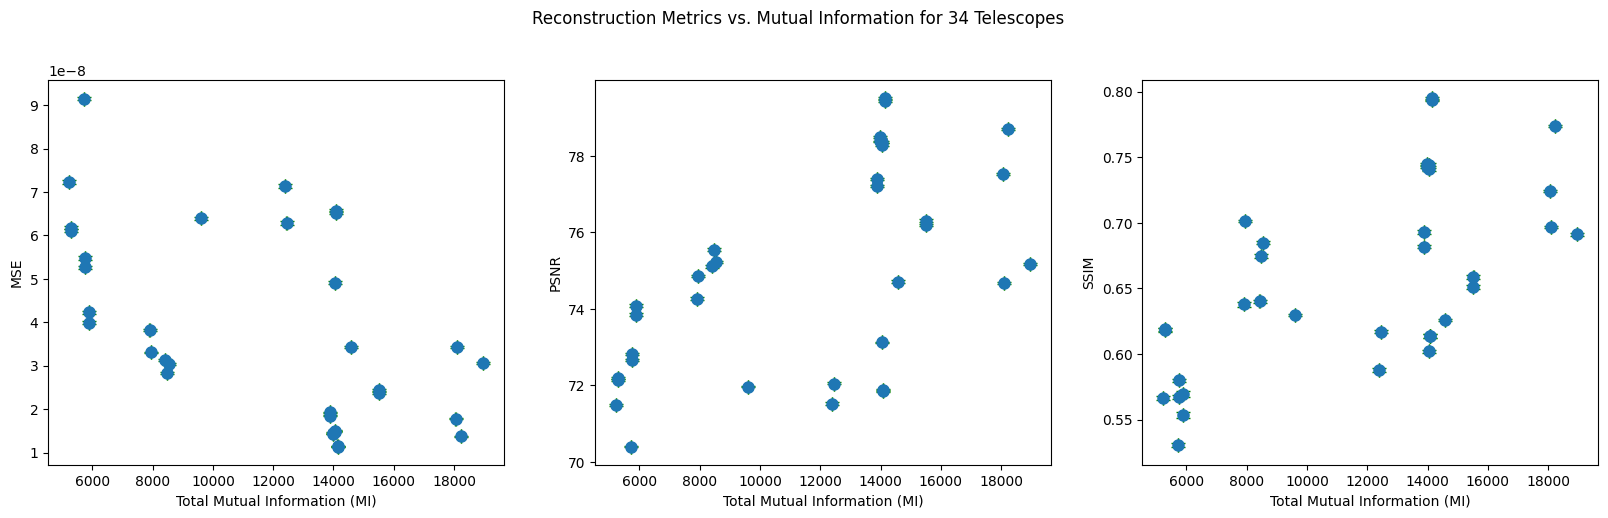

In [ ]:
lower_bounds_x = np.abs(np.array(mi_values) - np.array(mi_lower_bounds))
upper_bounds_x = np.abs(np.array(mi_upper_bounds) - np.array(mi_values))
plt.figure(figsize=(20, 5)) 
plt.subplot(1, 3, 1) 
# bounds for MSE 
lower_bounds_y = np.abs(np.array(mse_means) - np.array(mse_lower_bounds))
upper_bounds_y = np.abs(np.array(mse_upper_bounds) - np.array(mse_means))
plt.scatter(mi_values, mse_means) 
plt.errorbar(mi_values, mse_means, yerr=[lower_bounds_y, upper_bounds_y], xerr=[lower_bounds_x, upper_bounds_x], fmt='o', capsize=5, ecolor='green', markersize=8)
#plt.fill_between(mi_values, mse_lower_bounds, mse_upper_bounds, alpha=0.8, color='orange')
#plt.fill_between(mse_means, mi_lower_bounds, mi_upper_bounds, alpha=0.8, color='green')
plt.xlabel("Total Mutual Information (MI)")
plt.ylabel("MSE") 

plt.subplot(1, 3, 2)
# bounds for PSNR 
lower_bounds_y = np.abs(np.array(psnr_means) - np.array(psnr_lower_bounds))
upper_bounds_y = np.abs(np.array(psnr_upper_bounds) - np.array(psnr_means))
plt.scatter(mi_values, psnr_means)
plt.errorbar(mi_values, psnr_means, yerr=[lower_bounds_y, upper_bounds_y], xerr=[lower_bounds_x, upper_bounds_x], fmt='o', capsize=5, ecolor='green', markersize=8)
#plt.fill_between(mi_values, psnr_lower_bounds, psnr_upper_bounds, alpha=0.8, color='orange')
#plt.fill_between(psnr_means, mi_lower_bounds, mi_upper_bounds, alpha=0.8, color='green')
plt.xlabel("Total Mutual Information (MI)")
plt.ylabel("PSNR")

plt.subplot(1, 3, 3)
# bounds for SSIM
lower_bounds_y = np.abs(np.array(ssim_means) - np.array(ssim_lower_bounds))
upper_bounds_y = np.abs(np.array(ssim_upper_bounds) - np.array(ssim_means))
plt.scatter(mi_values, ssim_means)
plt.errorbar(mi_values, ssim_means, yerr=[lower_bounds_y, upper_bounds_y], xerr=[lower_bounds_x, upper_bounds_x], fmt='o', capsize=5, ecolor='green', markersize=8)
#plt.fill_between(mi_values, ssim_lower_bounds, ssim_upper_bounds, alpha=0.8, color='orange')
#plt.fill_between(ssim_means, mi_lower_bounds, mi_upper_bounds, alpha=0.8, color='green')
plt.xlabel("Total Mutual Information (MI)")
plt.ylabel("SSIM")

plt.suptitle("Reconstruction Metrics vs. Mutual Information for {} Telescopes".format(len(telescope_names)), y=1.02)

Text(0.5, 1.02, 'Reconstruction Metrics vs. Mutual Information for 14 Telescopes')

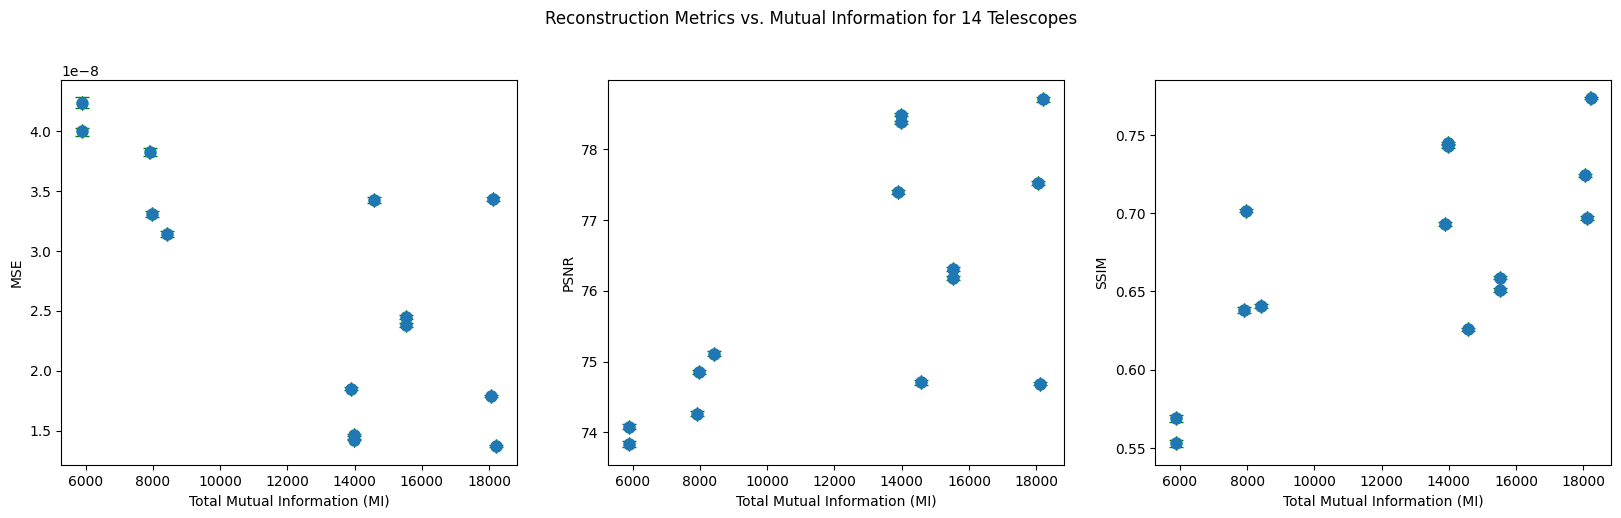

In [ ]:
lower_bounds_x = np.abs(np.array(mi_values) - np.array(mi_lower_bounds))
upper_bounds_x = np.abs(np.array(mi_upper_bounds) - np.array(mi_values))
plt.figure(figsize=(20, 5)) 
plt.subplot(1, 3, 1) 
# bounds for MSE 
lower_bounds_y = np.abs(np.array(mse_means) - np.array(mse_lower_bounds))
upper_bounds_y = np.abs(np.array(mse_upper_bounds) - np.array(mse_means))
plt.scatter(mi_values, mse_means) 
plt.errorbar(mi_values, mse_means, yerr=[lower_bounds_y, upper_bounds_y], xerr=[lower_bounds_x, upper_bounds_x], fmt='o', capsize=5, ecolor='green', markersize=8)
#plt.fill_between(mi_values, mse_lower_bounds, mse_upper_bounds, alpha=0.8, color='orange')
#plt.fill_between(mse_means, mi_lower_bounds, mi_upper_bounds, alpha=0.8, color='green')
plt.xlabel("Total Mutual Information (MI)")
plt.ylabel("MSE") 

plt.subplot(1, 3, 2)
# bounds for PSNR 
lower_bounds_y = np.abs(np.array(psnr_means) - np.array(psnr_lower_bounds))
upper_bounds_y = np.abs(np.array(psnr_upper_bounds) - np.array(psnr_means))
plt.scatter(mi_values, psnr_means)
plt.errorbar(mi_values, psnr_means, yerr=[lower_bounds_y, upper_bounds_y], xerr=[lower_bounds_x, upper_bounds_x], fmt='o', capsize=5, ecolor='green', markersize=8)
#plt.fill_between(mi_values, psnr_lower_bounds, psnr_upper_bounds, alpha=0.8, color='orange')
#plt.fill_between(psnr_means, mi_lower_bounds, mi_upper_bounds, alpha=0.8, color='green')
plt.xlabel("Total Mutual Information (MI)")
plt.ylabel("PSNR")

plt.subplot(1, 3, 3)
# bounds for SSIM
lower_bounds_y = np.abs(np.array(ssim_means) - np.array(ssim_lower_bounds))
upper_bounds_y = np.abs(np.array(ssim_upper_bounds) - np.array(ssim_means))
plt.scatter(mi_values, ssim_means)
plt.errorbar(mi_values, ssim_means, yerr=[lower_bounds_y, upper_bounds_y], xerr=[lower_bounds_x, upper_bounds_x], fmt='o', capsize=5, ecolor='green', markersize=8)
#plt.fill_between(mi_values, ssim_lower_bounds, ssim_upper_bounds, alpha=0.8, color='orange')
#plt.fill_between(ssim_means, mi_lower_bounds, mi_upper_bounds, alpha=0.8, color='green')
plt.xlabel("Total Mutual Information (MI)")
plt.ylabel("SSIM")

plt.suptitle("Reconstruction Metrics vs. Mutual Information for {} Telescopes".format(len(telescope_names)), y=1.02)